In [25]:
from source import create_db, create_df, heatmap, pieplot, barcharts, histograms, scatterplots, fit_model, feature_sel
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
import os

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif, RFECV, RFE
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif, RFECV, RFE
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score



from collections import Counter



pd.set_option("display.max_columns", None)

In [2]:
query = "SELECT * FROM df"
query_2 = "PRAGMA table_info(df)"
df = create_df(query, index=True)
df_info = create_df(query_2)

# EDA

## Informacion de Variables en el DataFrame

In [ ]:
df_info

## Comparacion de datos por año

### Proporcion de bajas en la empresa por año

In [ ]:
pieplot(df)

### Coparacion de la distribucion de los datos por año

#### 2015

Numero de columna: 0


0


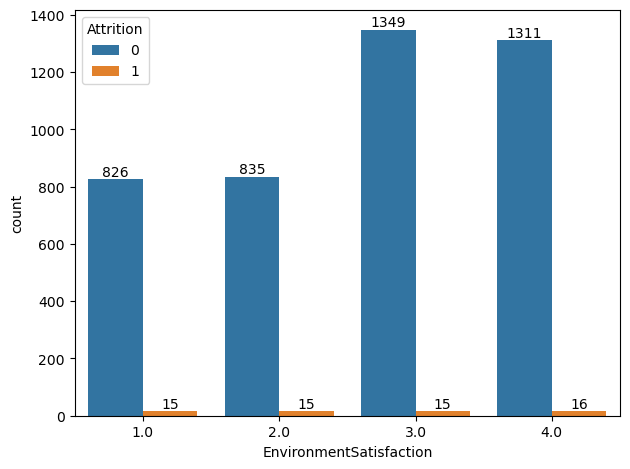

In [49]:
list_cat = df.select_dtypes("object").drop(columns="Attrition").columns
col = eval(input("Numero de columna:", ))
barcharts(df=df[df["Date"].dt.strftime("%Y") == "2015"], normalize=False, only=True, targ_col=list_cat[col])
print(col)

#### 2016

In [ ]:
list_cat = df.select_dtypes("object").drop(columns="Attrition").columns
col = eval(input("Numero de columna:", ))
barcharts(df=df[df["Date"].dt.strftime("%Y") == "2016"], normalize=False, only=True, targ_col=list_cat[col])
print(col)

## Mapa de Correlacion

In [ ]:
heatmap(df, annot=True)

## Mapas de Dispersion

In [ ]:
scatterplots(df)

## Histogramas Variables Numericas

In [ ]:
histograms(df)

## Diagramas de barra Variables Categoricas

In [ ]:
barcharts(df)

# Seleccion de Variables

In [16]:
vars_kb, vars_rfe, n_select = feature_sel(num_rfe=8)

In [4]:
vars = vars_rfe["gini_chi2"].values.tolist()
n_select.index.values.tolist()


SyntaxError: invalid syntax (288945800.py, line 3)

# Modelos

In [ ]:
model = fit_model(vars=vars, clf="rf", sample=None, year=2016)

In [ ]:
query = "SELECT * FROM df WHERE strftime('%Y', Date) = '2016'"
df = create_df(query, index=True)

target = "Attrition"

X = df[vars]
y = df[target]
    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pred = model.predict(X_test)
f1_score(y_test, pred, pos_label="1")

In [27]:
def models_info(year=2016, num_rfe=10):

    vars_kb, vars_rfe, n_select = feature_sel(num_rfe=num_rfe)

    if year:
        query = f"SELECT * FROM df WHERE strftime('%Y', Date) = '{year}'"
    else:
        query = "SELECT * FROM df"
    
    df = create_df(query, index=True)


    info_f1 = {i:[] for i in vars_rfe.columns}
    clfs = ["rf", "gb", "sv"]

    for v in vars_rfe:
        for clf in clfs:
            vars = vars_rfe[v].values.tolist()
            target = "Attrition"
            X = df[vars]
            y = df[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = fit_model(vars=vars, clf=clf, sample=None, year=year)
            pred = model.predict(X_test)
            info_f1[v].append(f1_score(y_test, pred, pos_label="1"))
            
    _ = {"recurrente": []}    
    for clf in clfs:
        vars = n_select.index.values.tolist()
        target = "Attrition"
        X = df[vars]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = fit_model(vars=vars, clf=clf, sample=None, year=year)
        pred = model.predict(X_test)
        _["recurrente"].append(f1_score(y_test, pred, pos_label="1"))
    
    info = pd.DataFrame(info_f1, index=clfs)

    display(info)


NameError: name 'SVC' is not defined

In [8]:
models_info(vars_rfe=vars_rfe)

NameError: name 'model' is not defined

In [23]:
vars_rfe

In [24]:
params = {"randomforestclassifier__n_estimators": range(25, 100, 25),
          "randomforestclassifier__max_depth": range(10, 40, 10),
          "randomforestclassifier__criterion": ["gini", "entropy", "log_loss"],
          "randomforestclassifier__max_features": ["sqrt", "log2", None]
         }

vars = vars_rfe["gini_chi2"].values.tolist()
# model, X_test, y_test = fit_model(vars, year=2016)

model_final = GridSearchCV(model, param_grid=params, cv=7, verbose=True, n_jobs=-1)

model_final.fit(X_train, y_train)

model_final.best_estimator_

0.9907514450867052

In [ ]:
best_params = {i[len("randomforestclassifier__"):]:j for i,j in model_final.best_params_.items()}

# prediction = model_final.best_estimator_.predict(X_test)

# f1_score(y_test, prediction, pos_label="1")

best_params

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

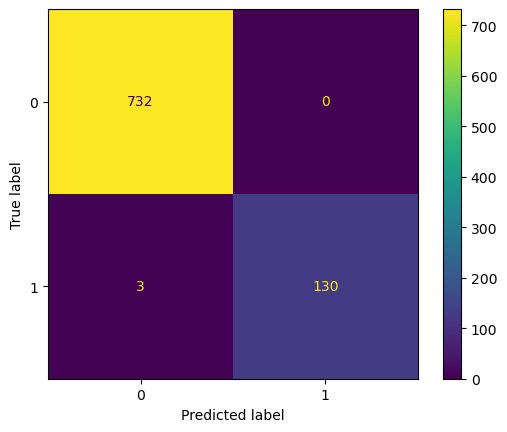

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_final, X_test, y_test);

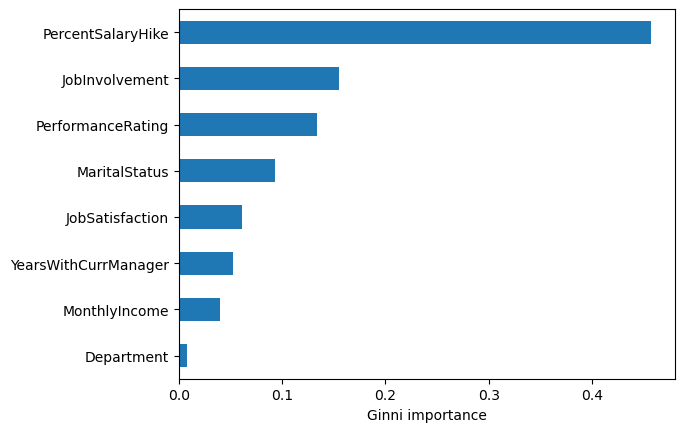

In [ ]:
feature_importances = pd.Series(model_final.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, index=vars)

feature_importances.sort_values().plot(kind="barh", xlabel="Ginni importance");

# KMeans

In [ ]:
silhouette_scores = []
inertia_errors = []

query = "SELECT * FROM df"
        
df = create_df(query, index=True)

target = "Attrition"

X = df[features]
y = df[target]

for n_clusters in range(2, 10):

    

    num_vals = X._get_numeric_data().columns.tolist()
    cat_vals = X.select_dtypes("object").columns.tolist()
    
    
        
    cat_processor = OneHotEncoder()
    num_processor = StandardScaler()

    processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

    model = make_pipeline(processor, 
                     KMeans(n_clusters=n_clusters, random_state=42))
    model.fit(X)

    silhouette_scores.append(silhouette_score(processor.fit_transform(X), model.named_steps["kmeans"].labels_))

    inertia_errors.append(model.named_steps["kmeans"].inertia_)


silhouette_serie = pd.Series(silhouette_scores, index=range(2, 10))
inertia_serie = pd.Series(inertia_errors, index=range(2, 10))


In [ ]:
model.score(X_test, y_test)

In [ ]:
plt.subplot(2,1,1)
silhouette_serie.plot(kind="line", ylabel="Silhouette Score", xlabel="N clusters")
plt.subplot(2,1,2)
inertia_serie.plot(kind="line", ylabel="Inertia", xlabel="N clusters")

plt.tight_layout()


In [ ]:
n_clusters = 4

query = "SELECT * FROM df"
        
df = create_df(query, index=True)

target = "Attrition"

X = df[features]
y = df[target]

num_vals = X._get_numeric_data().columns.tolist()
cat_vals = X.select_dtypes("object").columns.tolist()


    
cat_processor = OneHotEncoder()
num_processor = StandardScaler()

processor = ColumnTransformer(transformers=[("cat", cat_processor, cat_vals), ("num", num_processor, num_vals)])

model = make_pipeline(processor, 
                     KMeans(n_clusters=n_clusters, random_state=42))

model.fit(X)

In [ ]:
labels = model.named_steps["kmeans"].labels_

In [ ]:
query = "SELECT * FROM df"
df = create_df(query, index=True)

df["Labels"] = labels

df = df[df["Date"].dt.strftime("%Y") == "2016"]

In [ ]:
num_vals = df._get_numeric_data().drop("Labels", axis=1).columns.tolist()
cat_vals = df.select_dtypes("object").columns.tolist()

xgb = df.groupby(["Labels"], as_index=True)[num_vals].mean()

xgb

scaler = StandardScaler()

xgb_scal = pd.DataFrame(scaler.fit_transform(xgb), columns=xgb.columns, index=xgb.index)

In [ ]:
import plotly.express as px
fig = px.bar(xgb_scal.T.abs(), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()

In [ ]:
xgb = df.groupby("Labels", as_index=False)["retirementType"].value_counts(normalize=True)
xgb

In [ ]:
fig = px.bar(xgb, x="retirementType", y="proportion", color=xgb["Labels"].astype(str), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()

In [ ]:
xgb = df.groupby("Labels", as_index=False)["Department"].value_counts(normalize=True)

In [ ]:
fig = px.bar(xgb, x="Department", y="proportion", color=xgb["Labels"].astype(str), barmode="group", labels={"Labels":"<b>Cluster</b>"}, 
             template="plotly_white", color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title="<b>Feature</b>", yaxis_title="<b>Normalized median</b>")

fig.show()